In [1]:
import math
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
Uinf = 1.0                 # free-stream velocity
al = 2.0*math.pi/180       # angle of attack

In [3]:
class Panel:
    """Contains information related to a panel."""
    def __init__(self, xa, ya, xb, yb):
        """Initializes the panel.
        
        Arguments
        ---------
        xa, ya -- coordinates of the first end-point of the panel.
        xb, yb -- coordinates of the second end-point of the panel.
        """
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2            # collocation point (center-point)
        self.length = math.sqrt((xb-xa)**2+(yb-ya)**2)     # length of the panel
        
        # orientation of the panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.:
            self.beta = math.acos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = math.pi + math.acos(-(yb-ya)/self.length)
        
        self.n = [ math.cos(self.beta), math.sin(self.beta)]
        self.t = [-math.sin(self.beta), math.cos(self.beta)]
        
        self.kappa = 1                              # doublet strength
        self.vt = 0                                 # tangential velocity
        self.cp = 0                                 # pressure coefficient

96


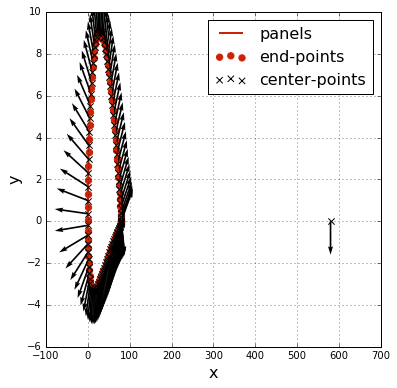

In [4]:
# plot NACA 2510 airfoil
N_panels = 96                 # number of panels desired

with open ('naca4415-il.csv') as file_name:
    x_ends, y_ends = numpy.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

# define the panels
panels = numpy.empty(N_panels+1, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
panels[-1] = Panel(x_ends[0], y_ends[0], x_ends[0]+1000, y_ends[0])

# plot the panels
size = 6
pyplot.figure(figsize=(size, size))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x', s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              scale=10, width=0.005)
pyplot.legend(['panels', 'end-points', 'center-points'], loc='best', prop={'size':16})
#pyplot.xlim(-0.75, 0.75)
#pyplot.ylim(-0.5, 0.5);
print(N_panels)

In [5]:
def get_doublet_panel_velocity(p,x,y):
    """Evaluates the velocity components induced at coordinates (x,y) by a panel p.
    
    Arguments
    ---------
    p -- panel from which the velocity is induced
    x -- x-coordinate in global frame
    y -- y-coordinate in global frame
    
    Returns
    -------
    (u,v)-components of velocity at (x,y)
    """
    
    x_p =  math.sin(p.beta)*(x-p.xb) - math.cos(p.beta)*(y-p.yb)
    y_p =  math.cos(p.beta)*(x-p.xb) + math.sin(p.beta)*(y-p.yb)
    
    u_p = -p.kappa/(2*math.pi)*(y_p/(x_p**2+y_p**2) - y_p/((x_p-p.length)**2+y_p**2))
    v_p =  p.kappa/(2*math.pi)*(x_p/(x_p**2+y_p**2) - (x_p-p.length)/((x_p-p.length)**2+y_p**2))
    
    u =  math.sin(p.beta)*u_p + math.cos(p.beta)*v_p
    v = -math.cos(p.beta)*u_p + math.sin(p.beta)*v_p
    
    return u, v

In [6]:
# compute the influence coefficient matrix
A = numpy.zeros((N_panels+1, N_panels+1), dtype=float)

for i, p_i in enumerate(panels[0:N_panels]):
    for j, p_j in enumerate(panels):
        A[i,j] = numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.n)
        if i == j:
            A[i,j] *= 1.001
A[-1,0] = -1
A[-1,-2] = 1
A[-1,-1] = -1

# compute the RHS of the linear system
b = numpy.zeros((N_panels+1, 1), dtype=float)
for i, p_i in enumerate(panels[0:N_panels]):
    b[i] = -numpy.dot(numpy.array([Uinf*math.cos(al), Uinf*math.sin(al)]), p_i.n)
    
print (A)
print (b)

[[ 6.99446056 -2.99463132 -0.29304584 ...,  1.63196299 -5.58260869
   3.49358702]
 [-0.46583154  2.33148685 -0.89489651 ..., -1.44949488  0.29750168
   0.6985978 ]
 [-0.04904856 -0.38364279  1.40521627 ...,  0.13433289  0.03890866
   0.2690653 ]
 ..., 
 [ 0.35923298 -1.57831716  0.26973463 ...,  2.47003648 -0.49369477
  -0.7399313 ]
 [-5.69852764  1.57362756  0.24421912 ..., -3.17036562  7.40555367
  -3.69891945]
 [-1.          0.          0.         ...,  0.          1.         -1.        ]]
[[-0.37502874]
 [-0.37502874]
 [-0.37307503]
 [-0.36415004]
 [-0.35416548]
 [-0.33933857]
 [-0.32573697]
 [-0.31330931]
 [-0.30417668]
 [-0.29637235]
 [-0.28795244]
 [-0.27897173]
 [-0.26978904]
 [-0.26104156]
 [-0.25229224]
 [-0.24302564]
 [-0.23274529]
 [-0.22140154]
 [-0.20979644]
 [-0.19725088]
 [-0.18430204]
 [-0.1707133 ]
 [-0.15649826]
 [-0.14196004]
 [-0.12575649]
 [-0.10796726]
 [-0.08800954]
 [-0.06529639]
 [-0.04000605]
 [-0.01302858]
 [ 0.01638992]
 [ 0.04735659]
 [ 0.07929933]
 [ 0.11

In [7]:
# solves the linear system
kappa = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.kappa = float(kappa[i])
print (kappa)

[[-53.01208486]
 [-53.09153881]
 [-53.01771609]
 [-52.81190808]
 [-52.4642288 ]
 [-51.96268318]
 [-51.30568462]
 [-50.4919591 ]
 [-49.52190411]
 [-48.39216007]
 [-47.09861045]
 [-45.64094402]
 [-44.02223946]
 [-42.24706239]
 [-40.31882238]
 [-38.24100633]
 [-36.01841149]
 [-33.65899073]
 [-31.17318146]
 [-28.56953614]
 [-25.85990807]
 [-23.05507567]
 [-20.16701866]
 [-17.20844765]
 [-14.18824788]
 [-11.11899452]
 [ -8.01289578]
 [ -4.88429458]
 [ -1.7509233 ]
 [  1.36738963]
 [  4.45300884]
 [  7.48515644]
 [ 10.44360714]
 [ 13.30967729]
 [ 16.06886507]
 [ 18.70884515]
 [ 21.21195069]
 [ 23.56851515]
 [ 25.77557008]
 [ 27.82569476]
 [ 29.6977744 ]
 [ 31.37108143]
 [ 32.83086496]
 [ 34.08436156]
 [ 35.13653281]
 [ 35.99147417]
 [ 36.61654235]
 [ 36.9871886 ]
 [ 37.11596792]
 [ 37.02590399]
 [ 36.75473565]
 [ 36.31976105]
 [ 35.71195958]
 [ 34.93548201]
 [ 33.98389847]
 [ 32.86444615]
 [ 31.59748943]
 [ 30.19952308]
 [ 28.68094205]
 [ 27.05437152]
 [ 25.3329685 ]
 [ 23.52862452]
 [ 21.64

In [8]:
for i, p_i in enumerate(panels[0:N_panels]):
    vt = numpy.array([0])
    for j, p_j in enumerate(panels):
        if i != j:
            vt = vt + numpy.dot(get_doublet_panel_velocity(p_j, p_i.xc, p_i.yc), p_i.t)
    if i == 0:
        R = math.sqrt((panels[1].xc-panels[0].xc)**2 + (panels[1].yc-panels[0].yc)**2)
        vt = vt - 0.5*(panels[1].kappa-panels[0].kappa)/R
    elif i == N_panels-1:
        R = math.sqrt((panels[N_panels-1].xc-panels[N_panels-2].xc)**2 + (panels[N_panels-1].yc-panels[N_panels-2].yc)**2)
        vt = vt - 0.5*(panels[N_panels-1].kappa-panels[N_panels-2].kappa)/R
    else:
        R = math.sqrt((panels[i+1].xc-panels[i-1].xc)**2 + (panels[i+1].yc-panels[i-1].yc)**2)
        vt = vt - 0.5*(panels[i+1].kappa-panels[i-1].kappa)/R
    vt = vt + numpy.dot(numpy.array([Uinf*math.cos(al), Uinf*math.sin(al)]), p_i.t)
    p_i.vt = float(vt)
    p_i.cp = 1.0 - (p_i.vt/Uinf)**2

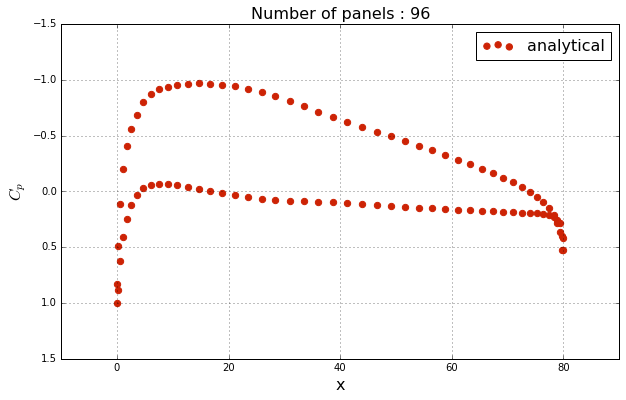

In [9]:
# plots the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)

pyplot.scatter([p.xc for p in panels[0:N_panels]], [p.cp for p in panels[0:N_panels]], color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(['analytical', 'source panel method'], loc='best', prop={'size':16})
#pyplot.xlim(-0.6, 0.6)
#pyplot.ylim(-1, 1.5)
pyplot.gca().invert_yaxis();